##DATA ANALYSIS AND EDA REGARDING THE BUSINESS DATASET OF YELP:

In [2]:
#Import libraries
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import sklearn.metrics
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [112]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [109]:
business = []
with open('/content/drive/MyDrive/yelp_academic_dataset_business.json', 'rb') as f:
    for i, line in enumerate(f):
        business.append(json.loads(line))

business = pd.DataFrame(business)


In [4]:
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


Let's look at the rating distribution of this huge dataset:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


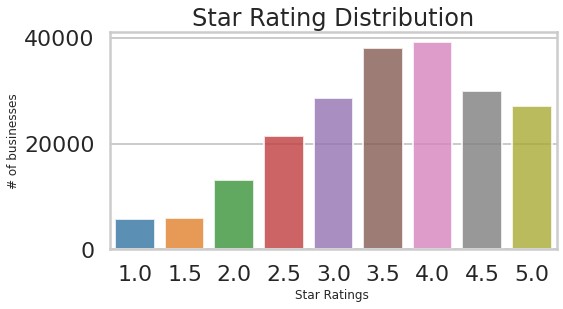

In [ ]:
#Get the distribution of the ratings
x=business['stars'].value_counts()
x=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

plt.show();

####Finding the top 10 business categories and also the distribution of restaurants in different places: 

First we eliminate all the cases where the business has no categories.

In [5]:
business= business[business['categories'].notna()]


In [6]:
import re
categ=';'.join(business['categories'])
cat=re.split(';|,', categ)
business_categories=pd.DataFrame([item.strip() for item in cat],columns=['category'])

In [7]:
businesscount=business_categories.category.value_counts().sort_values(ascending = False)[:10]
businesscount

Restaurants         63944
Shopping            34644
Food                32991
Home Services       22487
Beauty & Spas       20520
Health & Medical    19227
Local Services      15783
Automotive          14720
Nightlife           14211
Bars                12400
Name: category, dtype: int64

Since we are going to exclusively deal with the restaurants,we will take the subset of the cases where the business is just Restaurant type:

In [8]:
Restaurants = business.loc[[i for i in business['categories'].index if re.search('Restaurants', business['categories'][i])]]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


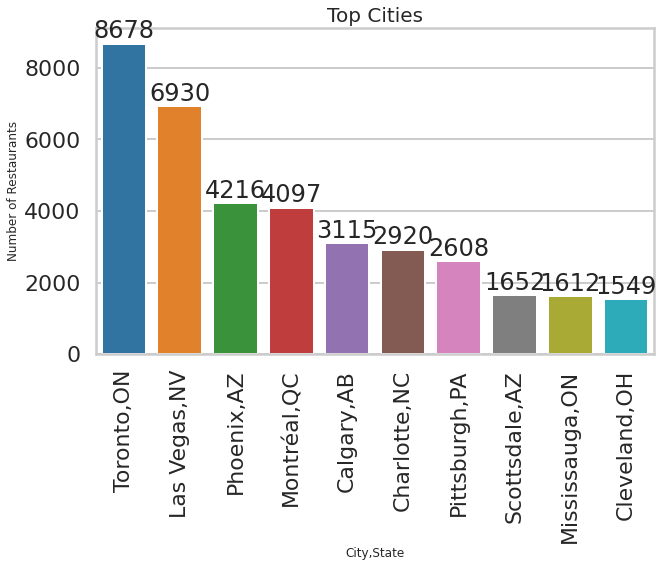

In [9]:
Restaurants['city_state'] = Restaurants['city'] + ',' + Restaurants['state']
city_count = Restaurants.city_state.value_counts().sort_values(ascending = False)[:10]

# plot
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(city_count.index, city_count.values)
plt.title("Top Cities",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('Number of Restaurants', fontsize = 12)
plt.xlabel('City,State', fontsize = 12)

#text labels
r = ax.patches
labels = city_count.values
for rect, label in zip(r, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 10, label, ha='center', va='bottom')

Now considering Toronto has the highest number of Restaurants, we subset our restaurant navigation further to just Toronto.

In [11]:
toronto_df=Restaurants[Restaurants.city=='Toronto']
toronto_df.shape

(8679, 15)

In [12]:
toronto_df.to_pickle('Toronto_rest')

In [16]:
toronto_df = pd.read_pickle('Toronto_rest')

In [17]:
toronto_df=toronto_df.drop(['address','city','state','hours','city_state'],axis=1)
toronto_df=toronto_df[toronto_df.is_open==1]

# Taking Only Restaurants which are open

In [18]:
toronto_df=toronto_df.drop('is_open',axis=1)


In [19]:
toronto_df.shape

(5462, 9)

Now, we notice that each business has multiple branches or outlets in Toronto, such as Tim Hortons has 58 instances with various ratings. This brings us to a plotting or analysis junction where we can which businesses have the highest number of outlets in Toronto.

####Plotiing the top 20 restaurants of Toronto:

Text(0.5, 0, 'Restaurant')

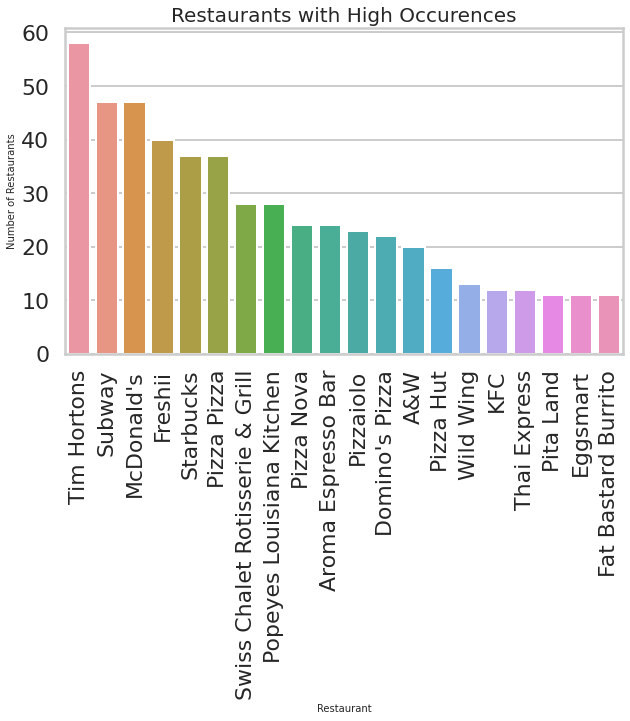

In [22]:
TopRes = toronto_df.name.value_counts().sort_values(ascending = False)[:20]

fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x = TopRes.index, y =TopRes.values)
plt.title("Restaurants with High Occurences",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.ylabel('Number of Restaurants', fontsize = 10)
plt.xlabel('Restaurant', fontsize = 10)

We see that Tim Hortons and Mc Donalds followed by Subway lead the graoh with the highest number of occurences 

In [23]:
toronto_df[toronto_df.name=='Tim Hortons'].shape

(58, 9)

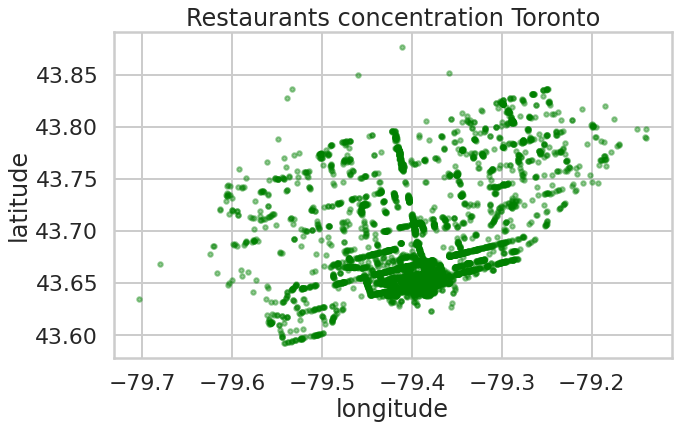

In [26]:
f, ax = plt.subplots(1, 1, figsize=(10,6))

#coordinates for Toronto
lat_t = 43.6532
lon_t = -79.3832

lon_t_min, lon_t_max = lon_t-0.5,lon_t+0.5
lat_t_min, lat_t_max = lat_t-0.5,lat_t+0.5

#subset the data
map_=toronto_df[(toronto_df["longitude"]>lon_t_min) & (toronto_df["longitude"]<lon_t_max) &\
                    (toronto_df["latitude"]>lat_t_min) & (toronto_df["latitude"]<lat_t_max)]

#plot
map_.plot(kind='scatter', x='longitude', y='latitude',
                color='green',alpha=0.4, ax=ax)
ax.grid('off')
ax.set_title("Restaurants concentration Toronto");




####Plotting the ratings obtained by Restaurants of the top 20 Restaurants:

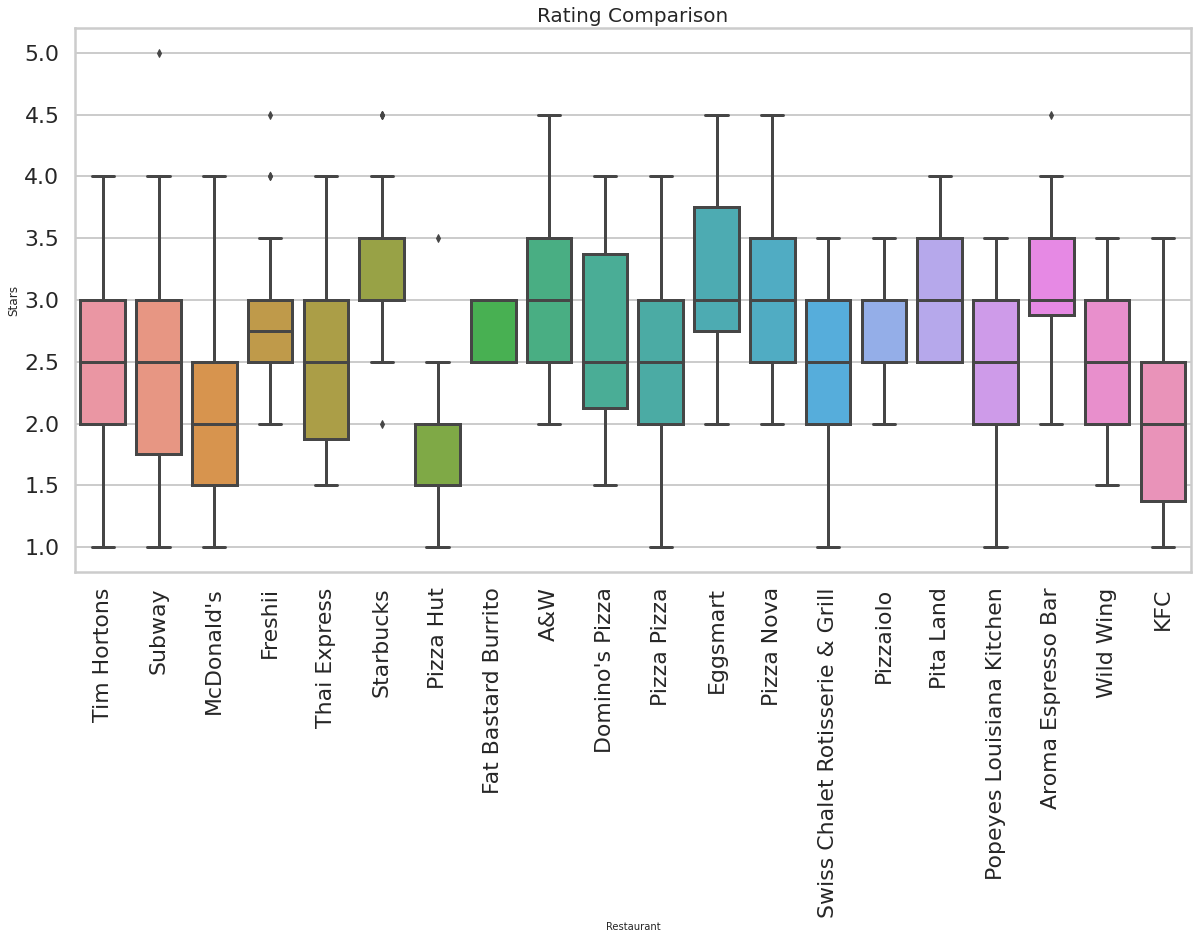

In [27]:
fig = plt.figure(figsize=(20, 10))
sns.boxplot(x = 'name', y = 'stars', data = toronto_df[toronto_df.name.isin(TopRes.index)])
plt.title("Rating Comparison",fontsize = 20)
plt.ylabel('Stars', fontsize = 12)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 90)
plt.xlabel('Restaurant', fontsize = 10);

In [28]:
TopRes.index

Index(['Tim Hortons', 'Subway', 'McDonald's', 'Freshii', 'Starbucks', 'Pizza Pizza', 'Swiss Chalet Rotisserie & Grill', 'Popeyes Louisiana Kitchen', 'Pizza Nova', 'Aroma Espresso Bar', 'Pizzaiolo', 'Domino's Pizza', 'A&W', 'Pizza Hut', 'Wild Wing', 'KFC', 'Thai Express', 'Pita Land', 'Eggsmart', 'Fat Bastard Burrito'], dtype='object')

Further there is a relation between the stars received by the restaurants and review counts:

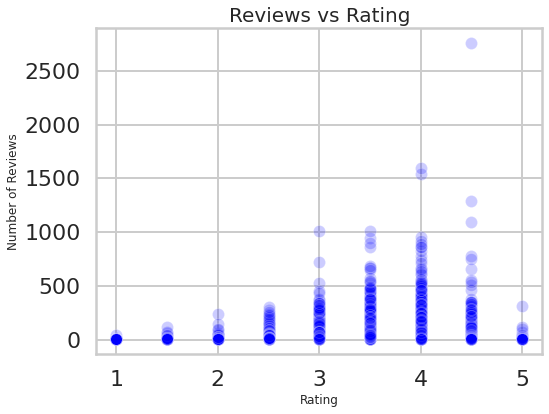

In [35]:
fig = plt.figure(figsize=(8, 6))
sns.scatterplot(x = 'stars', y = 'review_count',color='blue',alpha=0.2, data = toronto_df)
plt.title("Reviews vs Rating",fontsize = 20)
plt.ylabel('Number of Reviews', fontsize = 12)
plt.xlabel('Rating', fontsize = 12);

We see that the review count is mostly concentrated in the lower regions. Most ratings are based on less number of reviews and quite a few have received a high rating where the review count is also high. we might look at these Restaurants once where the review count is more than 500 and the rating is above 3.5

Text(0, 0.5, 'Restaurant')

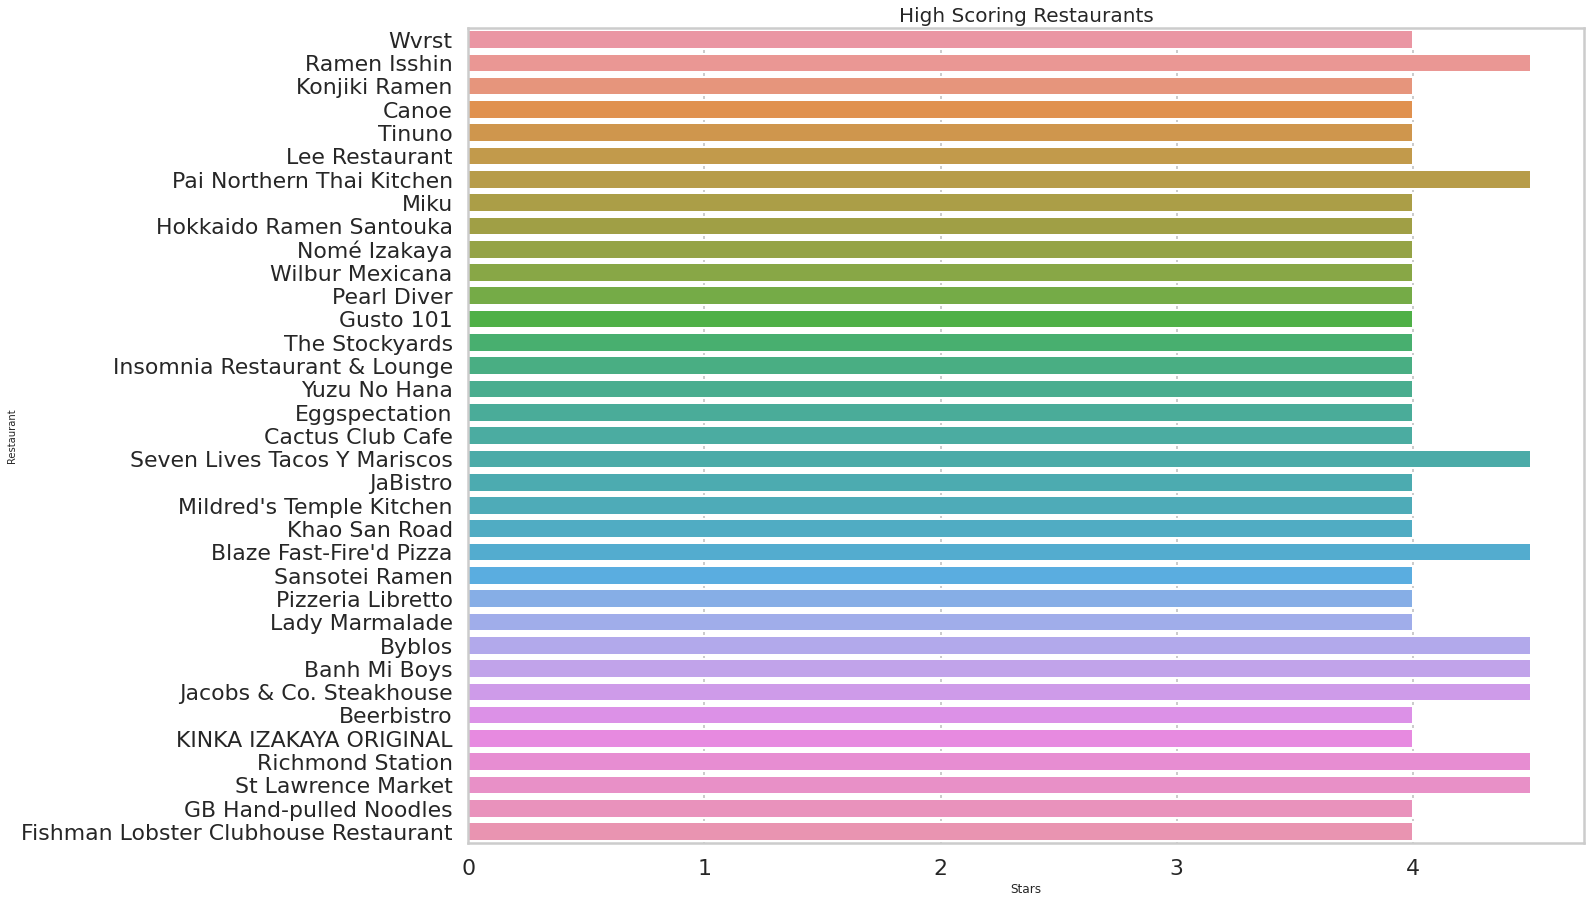

In [48]:
df=toronto_df[(toronto_df.stars>3.5) &(toronto_df.review_count>500)]
fig,ax=plt.subplots(figsize=(20,15))
sns.barplot(data=df,y=df.name,x=df.stars,ax=ax)
plt.title("High Scoring Restaurants",fontsize = 20)
plt.xlabel('Stars', fontsize = 12)
y_locs,y_labels = plt.yticks()
plt.ylabel('Restaurant', fontsize = 10)


In [49]:
toronto_df['attributes'] = toronto_df['attributes'].apply(lambda x: {} if x is None else x)
df = pd.json_normalize(toronto_df.attributes)

In [67]:
df


,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,Ambience,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService
0,True,u'beer_and_wine',True,1,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': True, 'validated':...",True,False,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'no',True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,'none',True,1,'casual',False,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': False, 'validated'...",True,False,False,NaN,NaN,'no',False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,'none',True,2,u'casual',True,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': False, 'validated'...",True,False,True,'loud',"{'dessert': False, 'latenight': False, 'lunch'...",'no',True,False,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,NaN,NaN,1,NaN,NaN,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,True,NaN,NaN,u'free',True,NaN,NaN,False,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,u'full_bar',True,3,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': False, 'validated'...",True,True,False,u'loud',"{'dessert': False, 'latenight': False, 'lunch'...",'free',True,True,True,False,NaN,NaN,NaN,"{'dj': False, 'background_music': False, 'no_m...",True,"{'monday': False, 'tuesday': False, 'friday': ...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,True,u'beer_and_wine',True,2,u'casual',True,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': True, 'validated':...",True,True,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'free',True,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5458,True,u'none',True,2,u'casual',True,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': False, 'validated'...",True,False,False,'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'free',False,NaN,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5459,True,u'full_bar',True,2,u'casual',True,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': True, 'validated':...",True,True,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'free',True,True,False,False,NaN,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5460,True,NaN,True,2,'casual',False,"{'romantic': False, 'intimate': False, 'classy...",NaN,True,False,False,NaN,NaN,NaN,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
def atomicrows(df,target_column):

    def splitListToRows(row,row_accumulator,target_column):

        new_row = row.to_dict()
        
        try:
            split_row = row[target_column]['Ambience'].replace('\'', "").replace('{','').replace('}','').split(",")
        
            for i in split_row:

                if i is None:
                    
                    continue
                
                try:

                    new_row["amb_"+i.split(":")[0].strip()] = i.split(":")[1].replace('\'', "").strip()
                    
                except:

                    f = 0

        except:

            f = 1

        row_accumulator.append(new_row)

    new_rows = [] 
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column))
    new_df = pd.DataFrame(new_rows)
    return new_df


In [53]:
df2 = atomicrows(toronto_df,'attributes')


df2.shape

(5462, 18)

In [54]:
df2.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,attributes,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","Vietnamese, Restaurants",False,False,False,False,False,False,False,False,True
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"{'OutdoorSeating': 'False', 'RestaurantsDelive...","Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,False,False,False,NaN,False,False,False,False
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"{'NoiseLevel': ''loud'', 'BusinessParking': '{...","Fast Food, Restaurants, Chicken Shop",False,False,False,False,NaN,False,False,False,False
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"{'DogsAllowed': 'False', 'OutdoorSeating': 'Tr...","Coffee & Tea, Restaurants, Sandwiches, Food",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"{'GoodForKids': 'True', 'RestaurantsGoodForGro...","Steakhouses, Restaurants, Nightlife, Seafood, ...",False,False,True,False,False,False,False,False,False


In [81]:
amb_cols = df2.columns[9:]

df2[amb_cols] = df2[amb_cols].fillna('False')

for i in amb_cols:
    df2[i].replace('None','False',inplace=True)
    

In [82]:
df2.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,attributes,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","Vietnamese, Restaurants",False,False,False,False,False,False,False,False,True
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"{'OutdoorSeating': 'False', 'RestaurantsDelive...","Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,False,False,False,False,False,False,False,False
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"{'NoiseLevel': ''loud'', 'BusinessParking': '{...","Fast Food, Restaurants, Chicken Shop",False,False,False,False,False,False,False,False,False
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"{'DogsAllowed': 'False', 'OutdoorSeating': 'Tr...","Coffee & Tea, Restaurants, Sandwiches, Food",False,False,False,False,False,False,False,False,False
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"{'GoodForKids': 'True', 'RestaurantsGoodForGro...","Steakhouses, Restaurants, Nightlife, Seafood, ...",False,False,True,False,False,False,False,False,False


In [83]:
df2.to_pickle('toronto_restaurant_amb2')

In [84]:
restaurants = pd.read_pickle('toronto_restaurant_amb2')
restaurants=restaurants[restaurants.attributes.notnull()]

restaurants.shape

(5462, 18)

We have already flattened out the ambiences using the atomicrow function and now we flatten the attributes manually

In [85]:
res = pd.merge(restaurants,df,left_index=True,right_index=True)
res.shape

(5462, 55)

In [86]:
res.drop(['Ambience','attributes'],axis=1,inplace=True)


In [240]:
res.head()

,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService,id
0,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",0,0,0,0,0,0,0,0,1,1,4,2,1,4,0,1,2,0,0,6,24,6,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45
1,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",0,0,0,0,0,0,0,0,0,1,2,2,1,0,0,0,2,0,0,4,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,376
2,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",0,0,0,0,0,0,0,0,0,1,2,2,2,4,2,0,2,0,2,1,3,1,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,318
3,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",0,0,0,0,0,0,0,0,0,1,6,0,1,3,0,0,0,0,2,4,0,5,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,147
4,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",0,0,1,0,0,0,0,0,0,1,5,2,3,4,0,0,2,2,0,7,8,0,2,2,2,0,0,0,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,36


In [61]:
res=pd.DataFrame()
for i in range(len(restaurants.attributes)):
  c=0
  d={}
  dict_=restaurants.iloc[i].attributes
  d['business_id']=restaurants.iloc[i]['business_id']
  d['name']=restaurants.iloc[i]['name']
  d['postal_code']=restaurants.iloc[i]['postal_code']
  d['latitude']=restaurants.iloc[i]['latitude']
  d['longitude']=restaurants.iloc[i]['longitude']
  d['stars']=restaurants.iloc[i]['stars']
  d['review_count']=restaurants.iloc[i]['review_count']
  d['categories']=restaurants.iloc[i]['categories']

  d['amb_romantic']= restaurants.iloc[i]['amb_romantic']
  d['amb_intimate']= restaurants.iloc[i]['amb_intimate']
  d['amb_classy']= restaurants.iloc[i]['amb_classy']
  d['amb_hipster']= restaurants.iloc[i]['amb_hipster']
  d['amb_divey']= restaurants.iloc[i]['amb_divey']
  d['amb_touristy']= restaurants.iloc[i]['amb_touristy']
  d['amb_trendy']= restaurants.iloc[i]['amb_trendy']
  d['amb_upscale']= restaurants.iloc[i]['amb_upscale']
  d['amb_casual']= restaurants.iloc[i]['amb_casual']

  for key,value in dict_.items():
    d[key]=value
  
  
  d=pd.DataFrame(d,columns=d.keys(),index=[i])
  res=pd.concat([res,d])

We have flattened the attributes and now we handle the NaNs and impute certain values and handle the missing values accordingly

In [90]:
res['RestaurantsPriceRange2']=res['RestaurantsPriceRange2'].replace(np.nan,0)
res['RestaurantsAttire']=res['RestaurantsAttire'].replace(np.nan,"streets")
res['Alcohol']=res['Alcohol'].replace(np.nan,"u'none'")
res['Caters']=res['Caters'].replace(np.nan,"False")
for i in res.columns[13:]:
  res[i]=res[i].replace(np.nan,"False")
res['BusinessParking']=res['BusinessParking'].apply(lambda x:'True'if "True" in x else "False")


res['GoodForMeal']=res['GoodForMeal'].astype('category').cat.codes.values

In [93]:
for i in res.columns[8:]:
  res[i]=res[i].astype('category').cat.codes.values

In [104]:
res.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",0,0,0,0,0,0,0,0,1,1,4,2,1,4,0,1,2,0,0,6,24,6,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",0,0,0,0,0,0,0,0,0,1,2,2,1,0,0,0,2,0,0,4,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",0,0,0,0,0,0,0,0,0,1,2,2,2,4,2,0,2,0,2,1,3,1,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",0,0,0,0,0,0,0,0,0,1,6,0,1,3,0,0,0,0,2,4,0,5,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",0,0,1,0,0,0,0,0,0,1,5,2,3,4,0,0,2,2,0,7,8,0,2,2,2,0,0,0,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we try and flatten the category column in order to increase more number of latent Factors in our Data

In [95]:
df = pd.Series(res['categories']).str.get_dummies(',')


In [96]:
df.columns = df.columns.str.strip()

df.drop(['Food','Restaurants'],axis=1,inplace=True)

df.shape

(5462, 545)

In [97]:
ratings=pd.DataFrame(res[['stars','categories']],index=res.index,columns=['stars','categories'])
ratings=pd.merge(ratings,df,left_index=True,right_index=True)

In [98]:
ratings

,stars,categories,Acai Bowls,Accessories,Accountants,Acne Treatment,Active Life,Afghan,African,Alternative Medicine,American (New),American (Traditional),Amusement Parks,Antiques,Appliances,Arabian,Arcades,Argentine,Art Classes,Art Galleries,Art Schools,Arts & Crafts,Arts & Entertainment,Asian Fusion,Australian,Automotive,Bagels,Bakeries,Bangladeshi,Barbeque,Bars,Bartenders,Beauty & Spas,Beer,Beer Bar,Belgian,Bistros,Bocce Ball,Books,Bookstores,Bowling,Brasseries,Brazilian,Breakfast & Brunch,Breweries,Brewpubs,British,Bubble Tea,Buffets,Burgers,...,Pool Halls,Pop-Up Restaurants,Portuguese,Poutineries,Pubs,Ramen,Recreation Centers,Roofing,Salad,Sandwiches,Seafood,Seafood Markets,Shaved Ice,Shaved Snow,Shopping,Shopping Centers,Smokehouse,Social Clubs,Soul Food,Soup,Southern,Spanish,Speakeasies,Specialty Food,Sports Bars,Sri Lankan,Steakhouses,Street Vendors,Sushi Bars,Swiss Food,Syrian,Tacos,Taiwanese,Tapas Bars,Tapas/Small Plates,Tea Rooms,Tex-Mex,Thai,Themed Cafes,Turkish,Ukrainian,Vegan,Vegetarian,Vietnamese,Waffles,Whiskey Bars,Wine Bars,Wineries,Women's Clothing,Yelp Events
0,4.0,"Vietnamese, Restaurants",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,3.0,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3.0,"Fast Food, Restaurants, Chicken Shop",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.5,"Coffee & Tea, Restaurants, Sandwiches, Food",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3.5,"Steakhouses, Restaurants, Nightlife, Seafood, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,4.0,"Sushi Bars, Restaurants, Japanese",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5458,3.5,"Mexican, Restaurants",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5459,4.0,"Vegan, Restaurants, Vegetarian, Salad",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5460,4.0,"Restaurants, Mediterranean",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we do some EDA on the categories obtained:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


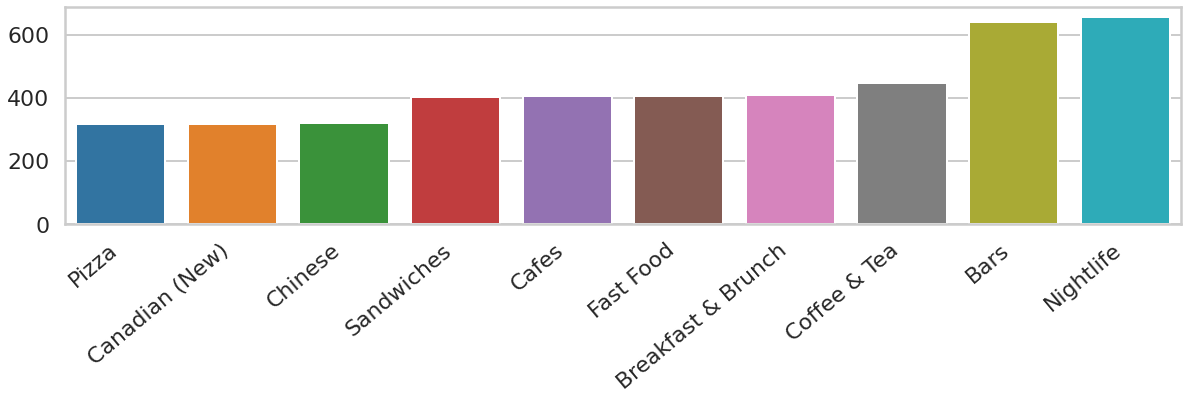

In [99]:
top_cats = df.sum().sort_values()[-10:]

plt.figure(figsize=(20,4))
ax = sns.barplot(top_cats.index,top_cats.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


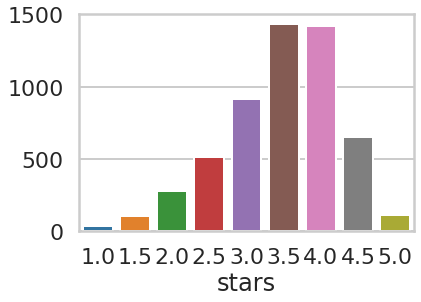

In [100]:
ratings = res.groupby('stars').count()['review_count']
sns.barplot(ratings.index,ratings.values)

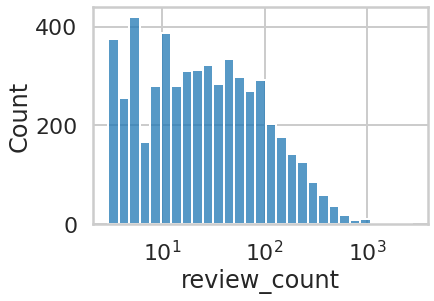

In [101]:
sns.histplot(res['review_count'],log_scale=True)

In [103]:
res.to_pickle('Toronto_Rest_Combo')

In [256]:
trescomb = pd.read_pickle('Toronto_Rest_Combo')

In [257]:
trescomb.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",0,0,0,0,0,0,0,0,1,1,4,2,1,4,0,1,2,0,0,6,24,6,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",0,0,0,0,0,0,0,0,0,1,2,2,1,0,0,0,2,0,0,4,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",0,0,0,0,0,0,0,0,0,1,2,2,2,4,2,0,2,0,2,1,3,1,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",0,0,0,0,0,0,0,0,0,1,6,0,1,3,0,0,0,0,2,4,0,5,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",0,0,1,0,0,0,0,0,0,1,5,2,3,4,0,0,2,2,0,7,8,0,2,2,2,0,0,0,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [105]:

import json 
def init_ds(json):
  ds={}
  keys = json.keys() 
  for k in keys:
     ds[k]= []
  return ds, keys 
def read_json(file): 
  dataset = {}
  keys = [] 
  with open(file) as file_lines:
    for count, line in enumerate(file_lines):
       data = json.loads(line.strip()) 
       if count ==0:
          dataset, keys = init_ds(data)
       for k in keys: 
         dataset[k].append(data[k]) 

    return pd.DataFrame(dataset)

In [113]:
reviews = read_json("/content/drive/MyDrive/yelp_academic_dataset_review.json")

In [115]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,I am actually horrified this place is still in...,2013-12-07 03:16:52
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,I love Deagan's. I do. I really do. The atmosp...,2015-12-05 03:18:11
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,"Oh happy day, finally have a Canes near my cas...",2017-01-14 21:56:57


In [116]:
reviews=reviews.drop(['date','text'],axis=1)

In [117]:
reviews['response']=[1 if y>3.5 else 0 for y in reviews['stars']]

In [118]:
reviews.drop(['response'])

,review_id,user_id,business_id,stars,useful,funny,cool,response
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2.0,5,0,0,0
1,UmFMZ8PyXZTY2QcwzsfQYA,nIJD_7ZXHq-FX8byPMOkMQ,lbrU8StCq3yDfr-QMnGrmQ,1.0,1,1,0,0
2,LG2ZaYiOgpr2DK_90pYjNw,V34qejxNsCbcgD8C0HVk-Q,HQl28KMwrEKHqhFrrDqVNQ,5.0,1,0,0,1
3,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1.0,0,0,0,0
4,6TdNDKywdbjoTkizeMce8A,UgMW8bLE0QMJDCkQ1Ax5Mg,IS4cv902ykd8wj1TR0N3-A,4.0,0,0,0,1


In [123]:
toronto_reviews

,review_id,user_id,business_id,stars,useful,funny,cool,response
25,mM8i91yWP1QbImEvz5ds0w,TZQSUDDcA4ek5gBd6BzcjA,qUWqjjjfpB2-4P3He5rsKw,4.0,0,0,0,1
44,nAm92_-WUQ084x9Uz9iFmA,iFEM16O5BeKvf_AHs6NzUQ,9Eghhu_LzEJgDKNgisf3rg,3.0,0,0,0,0
114,V3kZd0O3EeVuTBCKOW-M4g,Eg_VTAQwK3CxYTORNRWd2g,4m_hApwQ054v3ue_OxFmGw,5.0,2,0,0,1
134,Lx-ervsT1BqUL7OfW-Lb9A,IIE2OX5haarGNefY23R8BA,jM6JjZXFAQQANwdlEwbH3g,5.0,0,0,0,1
148,saJUbTtnictm8KFx6cNNJA,RRhco4irDXPk5EJmvuwr2w,PMPMHHLe9vFzcR67iCjgLA,5.0,0,0,2,1
...,...,...,...,...,...,...,...,...
8020622,9lEYzla0NLZyMsNV-b53Qg,E1hLHq6LZ6AoSJzW-oT4FQ,xF2zrVbXtB6TxMBPGJKxog,2.0,3,0,1,0
8020639,rBfr17beQCItyFrqdxOFEw,O8kmR1np3bcF_--U1vDkYA,5_2Lls-h_shbRGyUruLlTQ,5.0,2,0,0,1
8020643,X9a03IeCFtSeI1fOaicE2g,6ORiBNRD1FpaIJv3yLRZ4Q,9tfw-OEfpF0qC2hSzRks6g,5.0,1,1,1,1
8020780,2By_gXjZCbiEE1ZTO6hDcQ,sYl1niCXXzFbyI4UPouM3w,aFQQMQlUIW9KajS6oH5kyw,4.0,2,4,4,1


In [124]:
toronto_reviews.to_pickle("Toronto_reviews")

In [ ]:
res.reset_index()

,index,business_id,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,Ambience,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService
0,0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",False,False,False,False,False,False,False,False,True,True,u'beer_and_wine',True,1,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': True, 'validated':...",True,False,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'no',True,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",False,False,False,False,NaN,False,False,False,False,True,'none',True,1,'casual',False,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': False, 'validated'...",True,False,False,NaN,NaN,'no',False,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",False,False,False,False,NaN,False,False,False,False,True,'none',True,2,u'casual',True,"{'touristy': False, 'hipster': False, 'romanti...","{'garage': False, 'street': False, 'validated'...",True,False,True,'loud',"{'dessert': False, 'latenight': False, 'lunch'...",'no',True,False,True,True,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,1,NaN,NaN,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,NaN,True,NaN,NaN,u'free',True,NaN,NaN,False,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",False,False,True,False,False,False,False,False,False,True,u'full_bar',True,3,u'casual',False,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': False, 'validated'...",True,True,False,u'loud',"{'dessert': False, 'latenight': False, 'lunch'...",'free',True,True,True,False,NaN,NaN,NaN,"{'dj': False, 'background_music': False, 'no_m...",True,"{'monday': False, 'tuesday': False, 'friday': ...",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5457,5457,thzyiQZb16zD8wMliaEfRQ,Sushi Supreme,M4S 1Z8,43.700617,-79.396762,4.0,104,"Sushi Bars, Restaurants, Japanese",False,False,False,False,False,False,False,False,True,True,u'beer_and_wine',True,2,u'casual',True,"{'romantic': False, 'intimate': False, 'classy...","{'garage': False, 'street': True, 'validated':...",True,True,False,u'average',"{'dessert': False, 'latenight': False, 'lunch'...",u'free',True,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5458,5458,eUi3O-8Gqh_nJ_ZhO-25gQ,Get & Go Burrito,M3K 1G7,43.726656,-79.480365,3.5,43,"Mexican, Restaurants",False,False,False,Fa

In [ ]:
reviews=reviews.drop('review_id',axis=1)

In [242]:
from scipy.stats.stats import pearsonr

In [245]:
cols = res.columns[9:]

df_list=[]

for i in cols:
    
    value = pearsonr(res[i],res['stars'])

    corr = {'Feature':i , 'corr':value[0] , 'abscorr':abs(value[0])}

    df_list.append(corr)

df_corr = pd.DataFrame(df_list)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [264]:
trescomb['BusinessParking'] = trescomb['BusinessParking'].astype('float')

In [266]:
small_df = trescomb[['BusinessParking','review_count','latitude','DriveThru']]

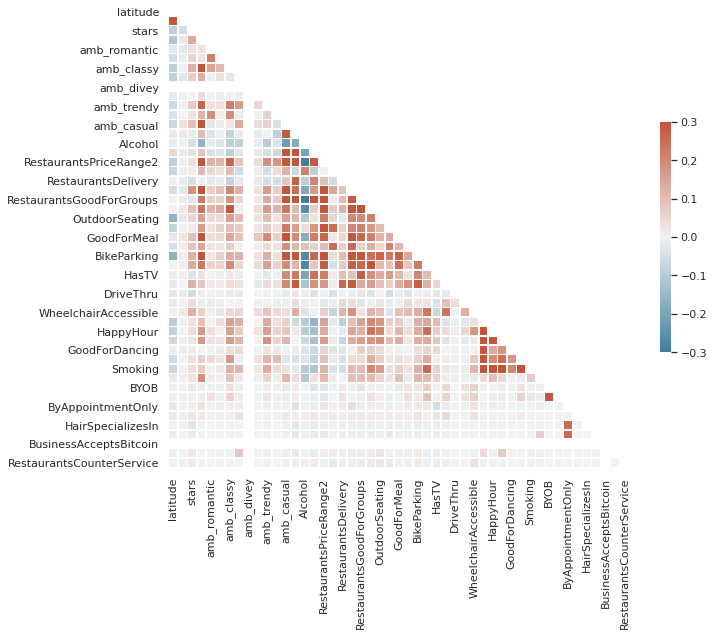

In [268]:

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(trescomb.corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(trescomb.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.tight_layout()


Text(0, 0.5, 'Corr')

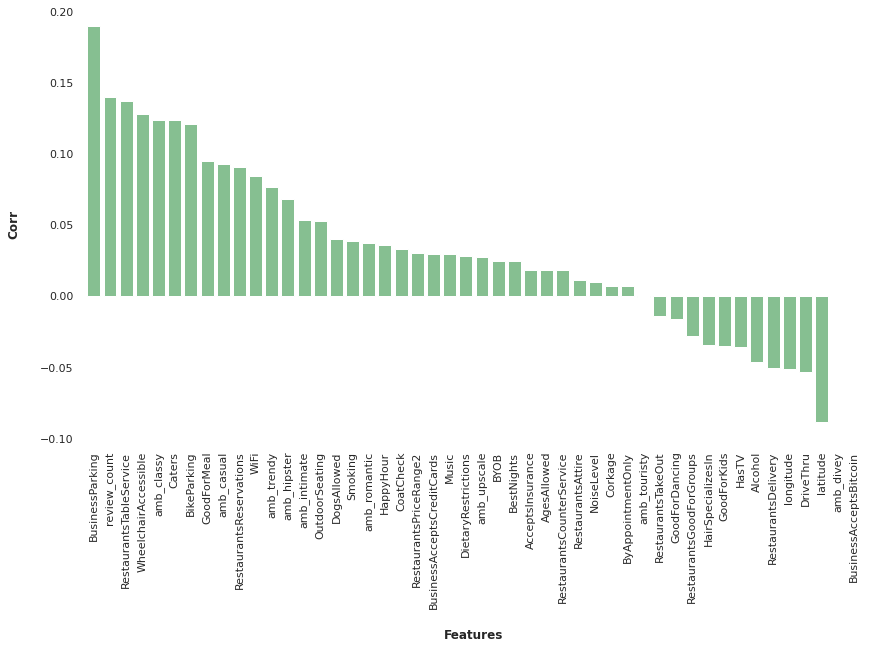

In [261]:
corr_matrix = trescomb.corr()

corr_avg_stars = corr_matrix['stars'].sort_values(ascending=False)

corr_avg_stars.pop('stars')

ax = corr_avg_stars.plot(kind='bar', sharex=False, figsize=(14,8), color = '#86bf91', zorder=2, width=0.8)

#despine
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlabel('Features', labelpad=20, weight='bold')
ax.set_ylabel('Corr', labelpad=20, weight='bold')


In [246]:
corr=df_corr.sort_values(by='abscorr',ascending=False)[:25]
corr

,Feature,corr,abscorr
13,BusinessParking,0.189287,0.189287
21,RestaurantsTableService,0.136596,0.136596
26,WheelchairAccessible,0.127286,0.127286
0,amb_classy,0.123654,0.123654
23,Caters,0.123064,0.123064
20,BikeParking,0.120840,0.120840
18,GoodForMeal,0.094894,0.094894
6,amb_casual,0.092395,0.092395
15,RestaurantsReservations,0.090383,0.090383
19,WiFi,0.083760,0.083760


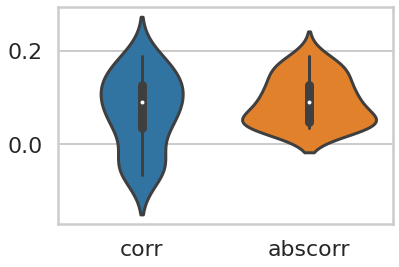

In [ ]:
sns.violinplot(data=corr);

As we remember, the Tim Hortons, Mc Donalds and Subway had the highest number of outlets. Let's see what is the response of people based on their ratings for these businesses.

In [ ]:
resp=res[res.name.isin(TopRes.index)][['business_id','name']]
resp.reset_index()

,index,business_id,name
0,1,8k62wYhDVq1-652YbJi5eg,Tim Hortons
1,33,AOhJfJVuEPUh_in7WHDnzQ,Subway
2,36,2vuAlukfUZf3vbHsexEeDw,McDonald's
3,38,kwXTdolA_0G2haHW4To5kA,Freshii
4,44,_o2fJBcVgLpy-L970Y7qYQ,Thai Express
...,...,...,...
516,5415,kqW_BKO3XCOx8ifbzQsnGA,McDonald's
517,5434,q9X0rwLBGehmRwXFqlWE-A,Aroma Espresso Bar
518,5442,vQXhuCQ4Wc3WWesp9hy3VQ,Pizza Hut
519,5447,undz-LtXIta312RP_DqmFQ,Subway


In [ ]:
resp=pd.merge(resp,reviews,how='inner',on="business_id")

In [ ]:
#resp.groupby("business_id")['stars'].mean()

#####Plotting for Tim Hortons:

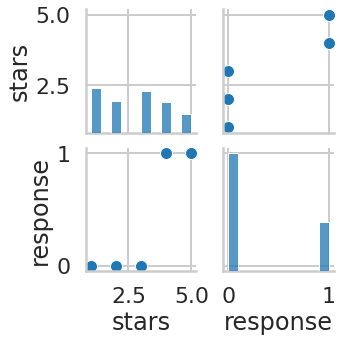

In [ ]:
sns.pairplot(data=resp[resp.name=='Tim Hortons'])

####Plotting for Subways:

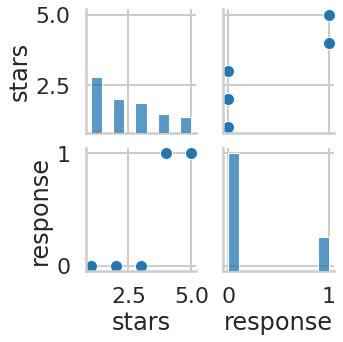

In [ ]:
sns.pairplot(data=resp[resp.name=='Subway'])

####Plotting for both:

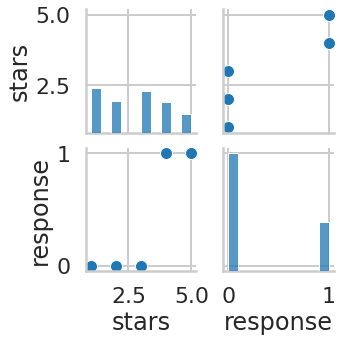

In [ ]:
sns.pairplot(data=resp[resp.name.isin(['Tim Hortons','Subways'])])

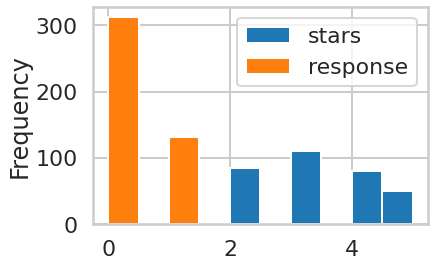

In [ ]:
resp[resp.name.isin(['Tim Hortons','Subways'])].plot(kind='hist')

###Looking into the Users with the maximum number of reviews:

In [ ]:
user=reviews.groupby('user_id').agg({'business_id':['count'],'stars':['mean']})

In [ ]:
user=user.sort_values([('business_id','count')],ascending=False)

In [ ]:
user.head(10)

,business_id,stars
,count,mean
user_id,,
CxDOIDnH8gp9KXzpBHJYXw,4331,3.247980
bLbSNkLggFnqwNNzzq-Ijw,2555,3.324853
ELcQDlf69kb-ihJfxZyL0A,2039,3.102011
PKEzKWv_FktMm2mGPjwd0Q,1972,3.680020
DK57YibC5ShBmqQl97CKog,1817,3.826087
U4INQZOPSUaj8hMjLlZ3KA,1762,3.968785
hWDybu_KvYLSdEFzGrniTw,1602,3.685393
QJI9OSEn6ujRCtrX06vs1w,1499,3.635090


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


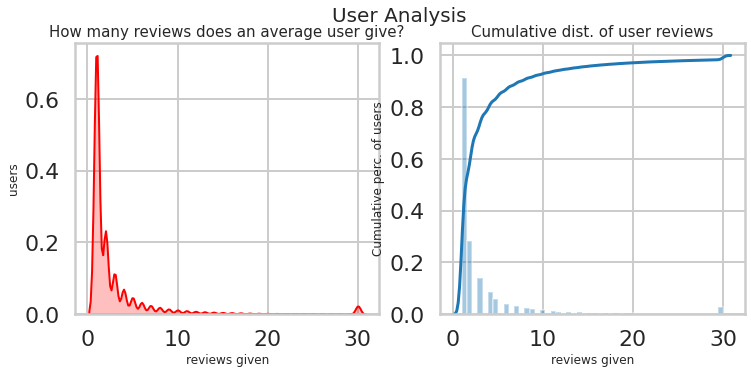

In [ ]:
user[('business_id','count')].loc[user[('business_id','count')]>30] = 30
plt.figure(figsize=(12,5))
plt.suptitle("User Analysis",fontsize=20)

plt.subplot2grid((1,2),(0,0))
#Cumulative Distribution
ax=sns.kdeplot(user[('business_id','count')],shade=True,color='r')
plt.title("How many reviews does an average user give?",fontsize=15)
plt.xlabel('reviews given', fontsize=12)
plt.ylabel('users', fontsize=12)

#Cumulative Distribution
plt.subplot2grid((1,2),(0,1))
sns.distplot(user[('business_id','count')],
             kde_kws=dict(cumulative=True))
plt.title("Cumulative dist. of user reviews",fontsize=15)
plt.ylabel('Cumulative perc. of users', fontsize=12)
plt.xlabel('reviews given', fontsize=12)

plt.show();


# Collaborative Filtering


In [141]:
res.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService,id
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",0,0,0,0,0,0,0,0,1,1,4,2,1,4,0,1,2,0,0,6,24,6,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",0,0,0,0,0,0,0,0,0,1,2,2,1,0,0,0,2,0,0,4,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",0,0,0,0,0,0,0,0,0,1,2,2,2,4,2,0,2,0,2,1,3,1,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",0,0,0,0,0,0,0,0,0,1,6,0,1,3,0,0,0,0,2,4,0,5,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",0,0,1,0,0,0,0,0,0,1,5,2,3,4,0,0,2,2,0,7,8,0,2,2,2,0,0,0,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4


In [166]:
toronto_reviews = reviews[reviews.business_id.isin(res.business_id.unique())]

In [262]:
toronto_reviews.head()

,index,review_id,user_id,business_id,stars,useful,funny,cool,response
0,25,mM8i91yWP1QbImEvz5ds0w,0,0,4.0,0,0,0,1
1,44,nAm92_-WUQ084x9Uz9iFmA,1,1,3.0,0,0,0,0
2,114,V3kZd0O3EeVuTBCKOW-M4g,2,2,5.0,2,0,0,1
3,134,Lx-ervsT1BqUL7OfW-Lb9A,3,3,5.0,0,0,0,1
4,148,saJUbTtnictm8KFx6cNNJA,4,4,5.0,0,0,2,1


In [167]:
toronto_reviews.reset_index(inplace=True)

In [168]:
user = toronto_reviews['user_id'].unique()
restaurant = toronto_reviews['business_id'].unique()


userid2idx = {o:i for i,o in enumerate(user)}
resid2idx = {o:i for i,o in enumerate(restaurant)}

In [169]:
len(toronto_reviews['business_id'].unique())

5462

In [170]:
toronto_reviews['business_id'] = toronto_reviews.business_id.apply(lambda x: resid2idx[x])
toronto_reviews['user_id'] = toronto_reviews.user_id.apply(lambda x: userid2idx[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [171]:
toronto_reviews.head()

,index,review_id,user_id,business_id,stars,useful,funny,cool,response
0,25,mM8i91yWP1QbImEvz5ds0w,0,0,4.0,0,0,0,1
1,44,nAm92_-WUQ084x9Uz9iFmA,1,1,3.0,0,0,0,0
2,114,V3kZd0O3EeVuTBCKOW-M4g,2,2,5.0,2,0,0,1
3,134,Lx-ervsT1BqUL7OfW-Lb9A,3,3,5.0,0,0,0,1
4,148,saJUbTtnictm8KFx6cNNJA,4,4,5.0,0,0,2,1


In [172]:
res['id'] = res.business_id.apply(lambda x: resid2idx[x])

In [173]:
res.head()

,business_id,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService,id
0,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",0,0,0,0,0,0,0,0,1,1,4,2,1,4,0,1,2,0,0,6,24,6,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45
1,8k62wYhDVq1-652YbJi5eg,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",0,0,0,0,0,0,0,0,0,1,2,2,1,0,0,0,2,0,0,4,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,376
2,0DnQh8SE8BSnvJltGCCiWg,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",0,0,0,0,0,0,0,0,0,1,2,2,2,4,2,0,2,0,2,1,3,1,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,318
3,NLaK58WvlNQdUunSIkt-jA,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",0,0,0,0,0,0,0,0,0,1,6,0,1,3,0,0,0,0,2,4,0,5,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,147
4,cicPsia8Wj-DNRkmLbD_xg,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",0,0,1,0,0,0,0,0,0,1,5,2,3,4,0,0,2,2,0,7,8,0,2,2,2,0,0,0,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,36


In [136]:
toronto_reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,response
25,mM8i91yWP1QbImEvz5ds0w,0,495,4.0,0,0,0,1
44,nAm92_-WUQ084x9Uz9iFmA,1,301,3.0,0,0,0,0
114,V3kZd0O3EeVuTBCKOW-M4g,2,103,5.0,2,0,0,1
134,Lx-ervsT1BqUL7OfW-Lb9A,3,284,5.0,0,0,0,1
148,saJUbTtnictm8KFx6cNNJA,4,154,5.0,0,0,2,1


In [175]:
res.drop("business_id",axis=1,inplace=True)

In [176]:
res.head()

,name,postal_code,latitude,longitude,stars,review_count,categories,amb_romantic,amb_intimate,amb_classy,amb_hipster,amb_divey,amb_touristy,amb_trendy,amb_upscale,amb_casual,RestaurantsTakeOut,Alcohol,GoodForKids,RestaurantsPriceRange2,RestaurantsAttire,RestaurantsDelivery,BusinessParking,RestaurantsGoodForGroups,RestaurantsReservations,OutdoorSeating,NoiseLevel,GoodForMeal,WiFi,BikeParking,RestaurantsTableService,HasTV,Caters,DriveThru,DogsAllowed,WheelchairAccessible,Music,HappyHour,BestNights,GoodForDancing,CoatCheck,Smoking,BusinessAcceptsCreditCards,BYOB,Corkage,ByAppointmentOnly,DietaryRestrictions,HairSpecializesIn,AcceptsInsurance,BusinessAcceptsBitcoin,AgesAllowed,RestaurantsCounterService,id
0,Mi Mi Restaurant,M4M 1Y3,43.666376,-79.348773,4.0,116,"Vietnamese, Restaurants",0,0,0,0,0,0,0,0,1,1,4,2,1,4,0,1,2,0,0,6,24,6,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,45
1,Tim Hortons,M5H 3V9,43.649859,-79.382060,3.0,8,"Bagels, Donuts, Food, Cafes, Coffee & Tea, Res...",0,0,0,0,0,0,0,0,0,1,2,2,1,0,0,0,2,0,0,4,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,376
2,Chick-N-Joy,M3A 1Z3,43.765279,-79.326248,3.0,11,"Fast Food, Restaurants, Chicken Shop",0,0,0,0,0,0,0,0,0,1,2,2,2,4,2,0,2,0,2,1,3,1,2,0,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,318
3,Zav Coffee Shop & Gallery,M4C 1J6,43.685608,-79.313936,4.5,24,"Coffee & Tea, Restaurants, Sandwiches, Food",0,0,0,0,0,0,0,0,0,1,6,0,1,3,0,0,0,0,2,4,0,5,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,147
4,The Keg Steakhouse + Bar,M4S 2B2,43.705843,-79.397841,3.5,91,"Steakhouses, Restaurants, Nightlife, Seafood, ...",0,0,1,0,0,0,0,0,0,1,5,2,3,4,0,0,2,2,0,7,8,0,2,2,2,0,0,0,0,4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,36


In [177]:
res_names = res.name.to_dict()

In [178]:
res.to_csv("processed_res", index = False)
toronto_reviews.to_csv("processed_reviews",index=False)

In [181]:
nusers = toronto_reviews.user_id.nunique()
nrest = toronto_reviews.business_id.nunique()
nusers, nrest


(90665, 5462)

In [183]:
np.random.seed=2017
from sklearn.model_selection import train_test_split
train_indices, val_indices = train_test_split(range(toronto_reviews.shape[0]), train_size=0.8)
trdf = toronto_reviews.iloc[train_indices]
valdf = toronto_reviews.iloc[val_indices]
trdf.shape, valdf.shape

((270662, 9), (67666, 9))

In [184]:
import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

2.4.1


In [185]:
L = 50
REG=5e-4

In [186]:
def create_bias(name, inp, n_in, reg):
    #x = Embedding(n_in, 1, input_length=1, embeddings_regularizer=l2(reg))(inp)
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

In [187]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

In [190]:
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
rest_input, rLmat = embedding_input('rest_input', nrest, L, REG)

In [192]:
user_input.shape, rest_input.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

In [193]:
user_bias = create_bias('user_bias', user_input, nusers, REG)
movie_bias = create_bias('movie_bias', rest_input, nrest, REG)

In [194]:
user_bias.shape, movie_bias.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

In [195]:
regression = Add(name="regression")([user_bias, movie_bias])

In [196]:
regression.shape

TensorShape([None, 1])

In [197]:
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

In [198]:
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid

In [199]:
cs = sigmoid_maker(0, 5.5)

In [200]:
output = Activation(cs, name="Sigmoid_Range")(regression)

In [227]:
model = Model([user_input, rest_input], output)
model.compile(Adam(0.001), loss='mse')

In [228]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
rest_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_bias (Embedding)           (None, 1, 1)         90665       user_input[0][0]                 
__________________________________________________________________________________________________
movie_bias (Embedding)          (None, 1, 1)         5462        rest_input[0][0]                 
____________________________________________________________________________________________

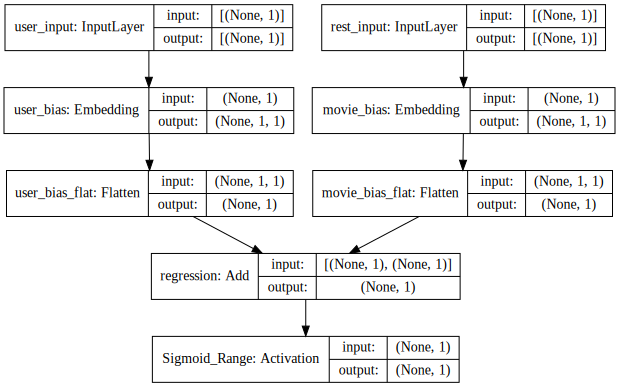

In [229]:
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

In [230]:
model.optimizer.lr=0.01
model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=64, epochs=5, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars))

Epoch 1/5
4230/4230 [==============================] - 9s 2ms/step - loss: 0.7925 - val_loss: 1.5604
Epoch 2/5
4230/4230 [==============================] - 9s 2ms/step - loss: 0.8123 - val_loss: 1.5585
Epoch 3/5
4230/4230 [==============================] - 9s 2ms/step - loss: 0.8040 - val_loss: 1.5698
Epoch 4/5
4230/4230 [==============================] - 9s 2ms/step - loss: 0.8067 - val_loss: 1.5743
Epoch 5/5
4230/4230 [==============================] - 9s 2ms/step - loss: 0.7975 - val_loss: 1.5723


In [231]:
model.optimizer.lr=0.001
model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=32, epochs=5, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars))

Epoch 1/5
8459/8459 [==============================] - 18s 2ms/step - loss: 0.7408 - val_loss: 1.5462
Epoch 2/5
8459/8459 [==============================] - 18s 2ms/step - loss: 0.7252 - val_loss: 1.5420
Epoch 3/5
8459/8459 [==============================] - 18s 2ms/step - loss: 0.7207 - val_loss: 1.5414
Epoch 4/5
8459/8459 [==============================] - 18s 2ms/step - loss: 0.7187 - val_loss: 1.5412
Epoch 5/5
8459/8459 [==============================] - 19s 2ms/step - loss: 0.7177 - val_loss: 1.5423


In [232]:
dfpreds = toronto_reviews[['business_id', 'stars', 'user_id']].copy()
dfpreds['predictions'] = model.predict([dfpreds.user_id, dfpreds.business_id]).ravel()

Text(0, 0.5, 'prediction')

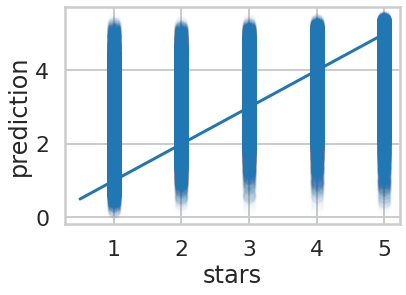

In [233]:
plt.scatter(dfpreds.stars, dfpreds.predictions, alpha=0.01)
plt.plot([0.5,5],[0.5,5])
plt.xlabel("stars")
plt.ylabel("prediction")

In [234]:
preds_stats=dfpreds.groupby('stars')['predictions'].describe().reset_index()
preds_stats

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,32329.0,2.142336,1.135770,0.080006,1.019844,2.005080,3.063719,5.393183
1,2.0,32204.0,2.922920,0.819769,0.253110,2.190868,2.944161,3.523265,5.308286
2,3.0,57906.0,3.405011,0.614597,0.238231,3.006629,3.397445,3.821222,5.394289
3,4.0,108510.0,3.826965,0.554315,0.232894,3.531484,3.910238,4.162243,5.411738
4,5.0,107379.0,4.372219,0.679236,0.286498,3.983089,4.514360,4.962600,5.463453


In [235]:
preds_stats_train = dfpreds.iloc[train_indices].groupby('stars')['predictions'].describe().reset_index()
preds_stats_train

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,25971.0,1.945782,1.066772,0.080006,1.003545,1.569882,2.812324,5.286274
1,2.0,25706.0,2.843754,0.786933,0.338824,2.100992,2.846452,3.439127,5.223590
2,3.0,46359.0,3.391848,0.579992,0.343549,3.003503,3.377259,3.792712,5.285796
3,4.0,86906.0,3.849418,0.508479,0.581298,3.578199,3.928233,4.154040,5.402177
4,5.0,85720.0,4.475153,0.597977,0.816124,4.117688,4.632963,4.980504,5.463453


In [236]:
preds_stats_val = dfpreds.iloc[val_indices].groupby('stars')['predictions'].describe().reset_index()
preds_stats_val

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,6358.0,2.945217,1.052836,0.137928,2.278457,3.014777,3.658393,5.393183
1,2.0,6498.0,3.236127,0.870613,0.253110,2.727989,3.270991,3.808263,5.308286
2,3.0,11547.0,3.457666,0.735045,0.238231,3.032490,3.489371,3.943064,5.394289
3,4.0,21604.0,3.736438,0.702162,0.232894,3.341600,3.795715,4.205191,5.411738
4,5.0,21659.0,3.964967,0.815100,0.286498,3.527340,4.066269,4.548885,5.460499


Text(0, 0.5, 'prediction')

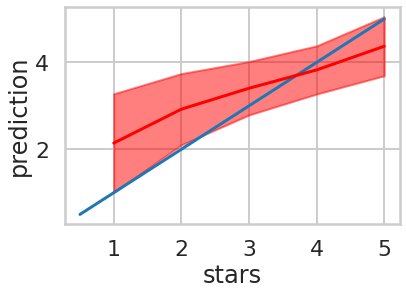

In [237]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats.stars, preds_stats['mean'], color="red")
plt.fill_between(preds_stats.stars, preds_stats['mean']-preds_stats['std'], preds_stats['mean']+preds_stats['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")

Text(0.5, 1.0, 'train')

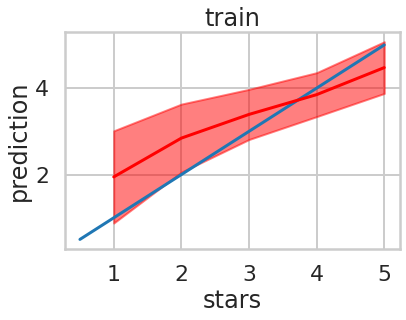

In [238]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_train.stars, preds_stats_train['mean'], color="red")
plt.fill_between(preds_stats_train.stars, preds_stats_train['mean']-preds_stats_train['std'], preds_stats_train['mean']+preds_stats_train['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")
plt.title('train')

Text(0.5, 1.0, 'val')

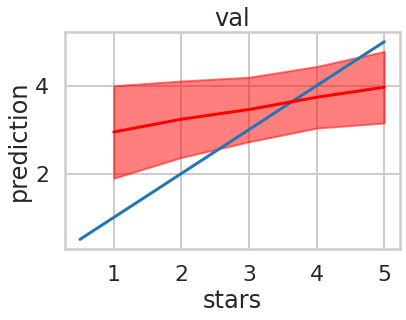

In [239]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_val.stars, preds_stats_val['mean'], color="red")
plt.fill_between(preds_stats_val.stars, preds_stats_val['mean']-preds_stats_val['std'], preds_stats_val['mean']+preds_stats_val['std'], color="red", alpha=0.5)
plt.xlabel("stars")
plt.ylabel("prediction")
plt.title('val')